# LLC4320 (Agulhas)

In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image

In [2]:
PERSISTENT_BUCKET = 'gs://leap-persistent/dhruvbalwada'
unfiltered_link = PERSISTENT_BUCKET + '/ssh_reconstruction_project/unfiltered_data.zarr'
filtered_link = PERSISTENT_BUCKET+'/ssh_reconstruction_project/filtered_data.zarr'

In [ ]:
da_unfiltered = xr.open_zarr(unfiltered_link)['ssh_unfiltered'].compute()
da_filtered = xr.open_zarr(filtered_link)['ssh_filtered'].compute()
da_it = da_unfiltered - da_filtered

## Split Time Slot into Random Patches

In [7]:
arr = da_it.isel(time=-1).fillna(0).values
patches = image.extract_patches_2d(arr, (256, 256), max_patches=128, random_state=42)
print(patches.shape)

(128, 256, 256)


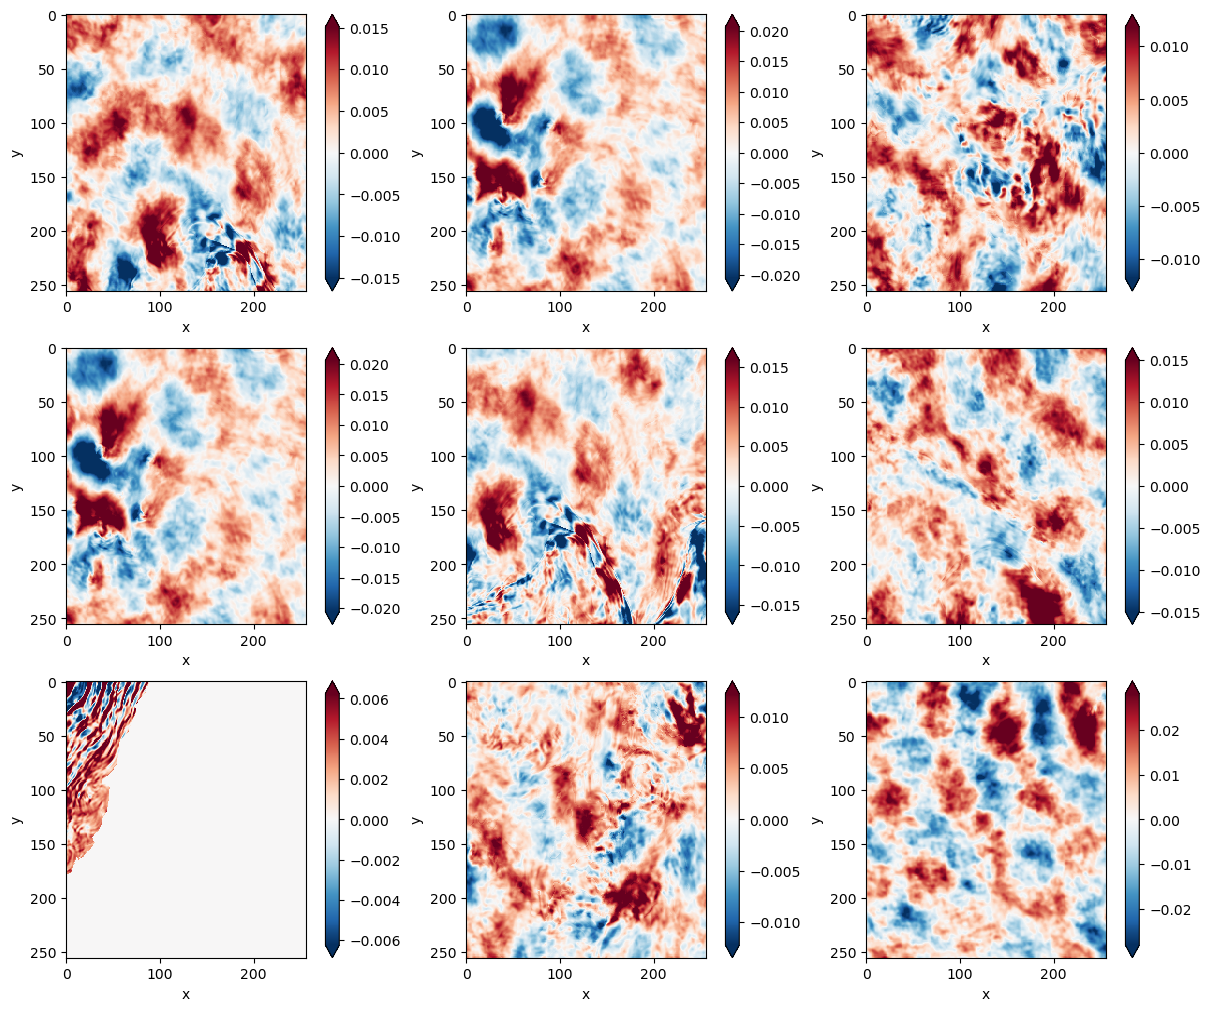

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10), constrained_layout=True)

for idx, sample in enumerate(np.random.randint(0, 127, 9)):
    i, j = divmod(idx, 3)
    
    xr.DataArray(patches[sample], dims=['x', 'y']).plot(x="x", y="y", robust=True, yincrease=False, ax=axes[i, j])

plt.show()

## Generating Dataset

In [2]:
def extract_patches(data, crop_size=256, max_patches=128):
    from sklearn.feature_extraction import image
    
    # time, rows, cols = data.shape
    base = da.empty((0, 256, 256), chunks=500, dtype=float)

    for arr in data:
        patches = image.extract_patches_2d(arr, (crop_size, crop_size), max_patches=max_patches, random_state=42)
        base = da.concatenate((base, patches) , axis=0)

    return base

In [3]:
def get_data_array(split):
        
    import xarray as xr

    link1 = 'gs://leap-persistent/dhruvbalwada/ssh_reconstruction_project/unfiltered_data.zarr'
    link2 = 'gs://leap-persistent/dhruvbalwada/ssh_reconstruction_project/filtered_data.zarr'

    da_unfiltered = xr.open_zarr(link1)['ssh_unfiltered']
    da_filtered = xr.open_zarr(link2)['ssh_filtered']
    da_it = da_unfiltered - da_filtered
    
    rng = np.random.default_rng(2019)
    arr = np.arange(70)
    rng.shuffle(arr)
    
    if split == 'train':
        ssh = extract_patches(da_unfiltered[arr[:49], :].fillna(0).values, crop_size=256, max_patches=256)
        bms = extract_patches(da_filtered[arr[:49], :].fillna(0).values, crop_size=256, max_patches=256)
        its = extract_patches(da_it[arr[:49], :].fillna(0).values, crop_size=256, max_patches=256)
        
        # Outputs need `.compute()` to convert to ndarray
        return ssh, bms, its
    
    # validation set:
    ssh = da_unfiltered[arr[49:56], 56:-56, 56:-56].fillna(0)
    bms = da_filtered[arr[49:56], 56:-56, 56:-56].fillna(0)
    its = da_it[arr[49:56], 56:-56, 56:-56].fillna(0)

    ssh = ssh.coarsen(i=256, j=256, boundary="exact").construct(i=("x_coarse", "x_fine"), j=("y_coarse", "y_fine"))
    ssh = ssh.stack(z=("time", "x_coarse", "y_coarse")).transpose('z', 'x_fine', 'y_fine')

    bms = bms.coarsen(i=256, j=256, boundary="exact").construct(i=("x_coarse", "x_fine"), j=("y_coarse", "y_fine"))
    bms = bms.stack(z=("time", "x_coarse", "y_coarse")).transpose('z', 'x_fine', 'y_fine')

    its = its.coarsen(i=256, j=256, boundary="exact").construct(i=("x_coarse", "x_fine"), j=("y_coarse", "y_fine"))
    its = its.stack(z=("time", "x_coarse", "y_coarse")).transpose('z', 'x_fine', 'y_fine')

    return ssh.values, bms.values, its.values

### Moving Dataset into a Permanent Bucket

In [55]:
import os
import fsspec

split = 'train'
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
path = f'{PERSISTENT_BUCKET}/LLC4320/dataset/{split}'
print(path)

ssh, bms, its = get_data_array(split=split)
print(ssh.shape, bms.shape, its.shape)

gs://leap-persistent/smhassanerfani/LLC4320/dataset/train
(12544, 256, 256) (12544, 256, 256) (12544, 256, 256)


In [6]:
def save_in_bucket(data, bucket_path):
    with fsspec.open(bucket_path, mode='wb') as f: # the `model='wb'` is crucial here
        np.save(f, data)

In [65]:
save_in_bucket(its.compute(), f'{path}/its.npy')

In [71]:
# list the dataset directory
gcs = fsspec.filesystem('gcs')
gcs.ls(PERSISTENT_BUCKET+'/LLC4320/dataset/train')

['leap-persistent/smhassanerfani/LLC4320/dataset/train/bms.npy',
 'leap-persistent/smhassanerfani/LLC4320/dataset/train/its.npy',
 'leap-persistent/smhassanerfani/LLC4320/dataset/train/ssh.npy']

In [68]:
# test if data is saved correctly
import os
import fsspec

PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
path = f'{PERSISTENT_BUCKET}/LLC4320/dataset/train/bms.npy'

with fsspec.open(path) as f:
    data = np.load(f)

print(data.shape)

(12544, 256, 256)
